In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
df = pd.read_csv("harder_synthetic_tasks.csv")
print(df.head())

    task id                            task name  \
0  53c6c547          Iterate killer technologies   
1  8c189ba8            Evolve innovative systems   
2  cc5c8b6a  Benchmark clicks-and-mortar portals   
3  973280e4       Incentivize turn-key bandwidth   
4  e870ae39                 Harness holistic roi   

                                         description      assigned to  \
0  Load format change interface system request no...   Timothy Bailey   
1   Navigate backend spelling error fix typo system.    Peggy Schmidt   
2           Click crash server fix bug click change.   Victoria Smith   
3  Interface issue render validation update issue...  Steven Ferguson   
4  Update task api navigate backend data loss issue.      James Roman   

   start date    due date priority       status  
0  2025-06-15  2025-06-22   Medium  In Progress  
1  2025-06-07  2025-06-17      Low         Open  
2  2025-05-26  2025-05-27     High  In Progress  
3  2025-05-29  2025-06-02   Medium    Completed 

preprocessing before naive bayes and svm 

In [25]:
le = LabelEncoder()
df['status_encoded'] = le.fit_transform(df['status'])
priority_order={'Low':0,'Medium':1,'High':2}
df['priority_encoded'] = le.fit_transform(df['priority'].map(priority_order))
df['assigned to_encoded'] = le.fit_transform(df['assigned to'])

In [42]:
df['lowered'] = df['description'].astype(str).str.lower()
df['name_lower']=df['task name'].astype(str).str.lower()

nltk.download('punkt')
nltk.download('punkt_tab')
df['tokens']=df['lowered'].apply(word_tokenize)
df['name_tokens']=df['name_lower'].apply(word_tokenize)

nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['no_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words and word.isalpha()])
df['name_no_stopwords'] = df['name_tokens'].apply(lambda x: [word for word in x if word not in stop_words and word.isalpha()])

df['lemmatized'] = df['no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['name_lemmatized'] = df['name_no_stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['clean_description'] = df['lemmatized'].apply(lambda x: " ".join(x))
df['clean_name'] = df['name_lemmatized'].apply(lambda x: " ".join(x))

df['text'] = df['clean_name'] + " " + df['clean_description']

df.head(10)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,task id,task name,description,assigned to,start date,due date,priority,status,tokens,filtered_tokens,...,no_stopwords,name_no_stopwords,lemmatized,name_lemmatized,clean_description,clean_name,text,status_encoded,priority_encoded,assigned to_encoded
0,53c6c547,Iterate killer technologies,Load format change interface system request no...,Timothy Bailey,2025-06-15,2025-06-22,Medium,In Progress,"[load, format, change, interface, system, requ...","[iterate, killer, technologies]",...,"[load, format, change, interface, system, requ...","[iterate, killer, technologies]","[load, format, change, interface, system, requ...","[iterate, killer, technology]",load format change interface system request no...,iterate killer technology,iterate killer technology load format change i...,1,1,920
1,8c189ba8,Evolve innovative systems,Navigate backend spelling error fix typo system.,Peggy Schmidt,2025-06-07,2025-06-17,Low,Open,"[navigate, backend, spelling, error, fix, typo...","[evolve, innovative, systems]",...,"[navigate, backend, spelling, error, fix, typo...","[evolve, innovative, systems]","[navigate, backend, spelling, error, fix, typo...","[evolve, innovative, system]",navigate backend spelling error fix typo system,evolve innovative system,evolve innovative system navigate backend spel...,2,0,760
2,cc5c8b6a,Benchmark clicks-and-mortar portals,Click crash server fix bug click change.,Victoria Smith,2025-05-26,2025-05-27,High,In Progress,"[click, crash, server, fix, bug, click, change...","[benchmark, clicks-and-mortar, portals]",...,"[click, crash, server, fix, bug, click, change]","[benchmark, portals]","[click, crash, server, fix, bug, click, change]","[benchmark, portal]",click crash server fix bug click change,benchmark portal,benchmark portal click crash server fix bug cl...,1,2,962
3,973280e4,Incentivize turn-key bandwidth,Interface issue render validation update issue...,Steven Ferguson,2025-05-29,2025-06-02,Medium,Completed,"[interface, issue, render, validation, update,...","[incentivize, turn-key, bandwidth]",...,"[interface, issue, render, validation, update,...","[incentivize, bandwidth]","[interface, issue, render, validation, update,...","[incentivize, bandwidth]",interface issue render validation update issue...,incentivize bandwidth,incentivize bandwidth interface issue render v...,0,1,883
4,e870ae39,Harness holistic roi,Update task api navigate backend data loss issue.,James Roman,2025-06-06,2025-06-09,Medium,Completed,"[update, task, api, navigate, backend, data, l...","[harness, holistic, roi]",...,"[update, task, api, navigate, backend, data, l...","[harness, holistic, roi]","[update, task, api, navigate, backend, data, l...","[harness, holistic, roi]",update task api navigate backend data loss issue,harness holistic roi,harness holistic roi update task api navigate ...,0,1,367
5,3b207040,Evolve synergistic e-tailers,Warning typo load error update navigate change.,Alicia Reynolds,2025-06-17,2025-06-22,Medium,In Progress,"[warning, typo, load, error, update, navigate,...","[evolve, synergistic, e-tailers]",...,"[warning, typo, load, error, update, navigate,...","[evolve, synergistic]","[warning, typo, load, error, update, navigate,...","[evolve, synergistic]",warning typo load error update navigate change,evolve synergistic,evolve synergistic warning typo load error upd...,1,1,23
6,1ef4620e,Scale bleeding-edge mindshare,Interface backend fix form api error request.,Melissa Reese,2025-05-29,2025-06-05,Medium,Open,"[interface, backend, fix, form, api, error, re...","[scale, bleeding-edge, mindshare]",...,"[interface, backend, fix, form, api, error, re...","[scale, mindshare]","[interface, backend, fix, form, api, error, re...","[scale, mindshare]",interface backend fix form api error request,scale mindshare,scale mindshare interface backend fix form api...,2,1,660
7,29dcbde1,Generate innovative supply-chains,Crash change load interface critical update up...,Tina Miller,2025-05-30,2025-05-31,High,Completed,"[crash, change, 

naive bayes model

In [44]:
#tf-idf 
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_vect = vectorizer.fit_transform(df['text'])  # shape: (n_samples, n_features)
y = df['priority_encoded']

X_train_naive, X_test_naive, y_train_naive, y_test_naive = train_test_split(X_vect, y, test_size=0.2, random_state=42)
nb_model = MultinomialNB()
nb_model.fit(X_train_naive, y_train_naive)

y_pred_naive2= nb_model.predict(X_test_naive)

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.62      0.71        61
           1       0.65      0.93      0.77        75
           2       0.76      0.55      0.64        64

    accuracy                           0.71       200
   macro avg       0.75      0.70      0.70       200
weighted avg       0.74      0.71      0.71       200



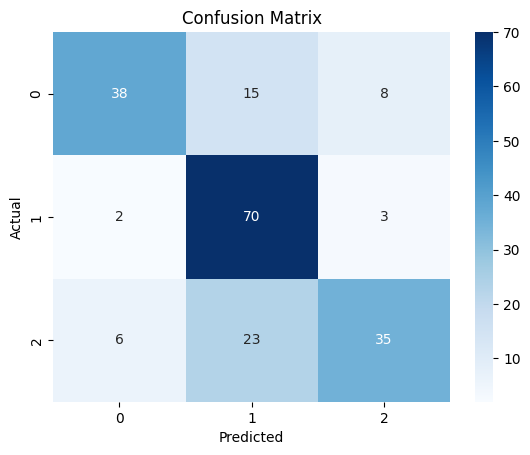

In [35]:
print("Classification Report:\n", classification_report(y_test_naive, y_pred_naive2))

# Confusion Matrix
cm = confusion_matrix(y_test_naive, y_pred_naive2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=nb_model.classes_, yticklabels=nb_model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

svm model

In [ ]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_vect = vectorizer.fit_transform(df['text'])
y = df['priority_encoded']
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# Train SVM Model
svm_model = SVC(kernel='linear')  
svm_model.fit(X_train_svm, y_train_svm)

# Predict
y_pred_svm = svm_model.predict(X_test_svm)


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.66      0.71        61
           1       0.71      0.85      0.78        75
           2       0.71      0.64      0.67        64

    accuracy                           0.72       200
   macro avg       0.73      0.72      0.72       200
weighted avg       0.73      0.72      0.72       200



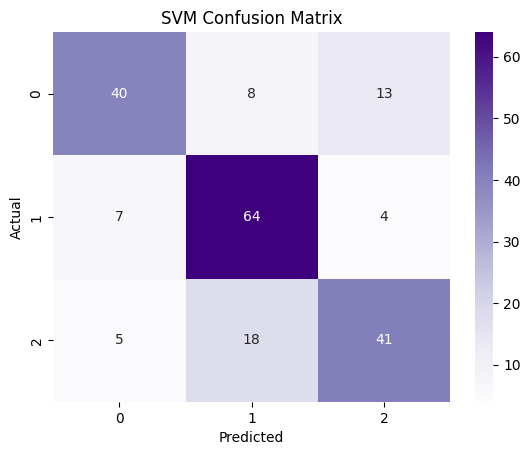

In [41]:
print("Classification Report:\n", classification_report(y_test_svm, y_pred_svm))

# Confusion Matrix
cm = confusion_matrix(y_test_svm, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()